In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
import pickle

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Unnamed: 0,Dia,Impresiones,Clics,Conversiones,Coste,dia_semana,mes,Conversiones_lag1,Conversiones_lag2,...,Coste_lag1,Coste_lag2,Coste_lag3,Coste_lag4,Coste_lag5,Coste_lag6,Coste_lag7,Coste_lag8,Coste_lag9,Coste_lag10
0,2015-01-11,2015-01-11,40490.0,709.0,6.0,92.36,6,0,4.0,4.0,...,76.28,77.50,74.69,81.32,88.80,40.79,53.13,80.37,104.24,65.62
1,2015-01-12,2015-01-12,37826.0,690.0,6.0,89.62,0,0,6.0,4.0,...,92.36,76.28,77.50,74.69,81.32,88.80,40.79,53.13,80.37,104.24
2,2015-01-13,2015-01-13,39804.0,787.0,10.0,101.76,1,0,6.0,6.0,...,89.62,92.36,76.28,77.50,74.69,81.32,88.80,40.79,53.13,80.37
3,2015-01-14,2015-01-14,41566.0,831.0,5.0,111.02,2,0,10.0,6.0,...,101.76,89.62,92.36,76.28,77.50,74.69,81.32,88.80,40.79,53.13
4,2015-01-15,2015-01-15,40663.0,771.0,7.0,102.51,3,0,5.0,10.0,...,111.02,101.76,89.62,92.36,76.28,77.50,74.69,81.32,88.80,40.79


In [4]:
# Eliminamos las columnas 'Unnamed: 0', 'Conversiones' y 'Día' que no serán features en el modelo.
X = train.drop(['Unnamed: 0','Conversiones', 'Dia'], axis=1)

A continuación, usaremos Pipeline de sklearn para crear un modelo predictivo "Pipeline". Los pasos son los siguientes:
- One-hot encoding para variables categóricas: Crearemos una función que asigne un valor único a cada característica de una variable categórica. En nuestro caso, asignaremos un valor único a cada día de la semana y otro valor único a cada mes del año.

- Eliminación recursiva de features con validación cruzada (RFECV): A menudo ocurre que algunas características agregan poca capacidad predictiva a un modelo e incluso pueden empeorar la precisión del modelo. Veremos cuáles son y las eliminaremos.

- Modelo final de entrenamiento: Encontrar el mejor modelo después de eliminar las features.

In [5]:
# Creamos una función que para cada valor único de una varible categórica.
cat_cols = ['mes', 'dia_semana']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)

In [6]:
# Creamos el modelo de regresión lineal.
regres = linear_model.LinearRegression(fit_intercept=True)

Para el ajuste de parámetros y la selección de características, la validación cruzada se realizará utilizando el conjunto de train ya que para realizar un pronóstico de series temporales es relevante que los datos de test sean posteriores a los datos de train.

Esto también se aplica a cada pliegue en la validación cruzada. Por lo tanto, usamos una división de series de tiempo para crear dos pliegues para la validación cruzada como veremos a continuación. Cada trama de series de tiempo representa una división separada de entrenamiento / prueba, con el conjunto de entrenamiento coloreado en azul y el conjunto de pruebas coloreado en rojo.

In [7]:
tscv = TimeSeriesSplit(n_splits=2)

In [8]:
train.dtypes

Unnamed: 0             object
Dia                    object
Impresiones           float64
Clics                 float64
Conversiones          float64
Coste                 float64
dia_semana              int64
mes                     int64
Conversiones_lag1     float64
Conversiones_lag2     float64
Conversiones_lag3     float64
Conversiones_lag4     float64
Conversiones_lag5     float64
Conversiones_lag6     float64
Conversiones_lag7     float64
Conversiones_lag8     float64
Conversiones_lag9     float64
Conversiones_lag10    float64
Coste_lag1            float64
Coste_lag2            float64
Coste_lag3            float64
Coste_lag4            float64
Coste_lag5            float64
Coste_lag6            float64
Coste_lag7            float64
Coste_lag8            float64
Coste_lag9            float64
Coste_lag10           float64
dtype: object

In [9]:
# Definimos la siguiente función para gestionar los problemas de formato fecha de la columna 'Dia'.
def fec(f):
   return datetime.strptime(f, '%Y-%m-%d')

train['Dia'] = train['Dia'].apply(fec)

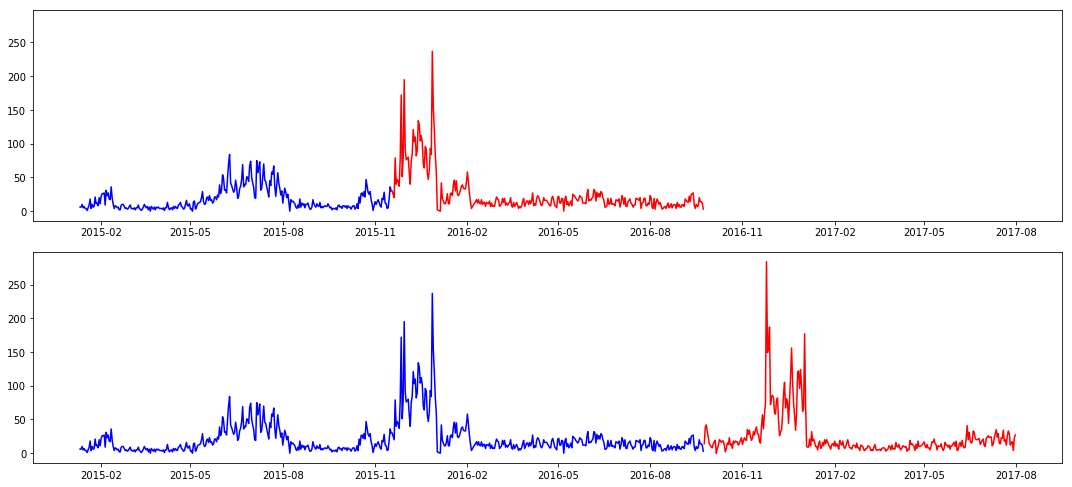

In [20]:
Conversiones_ts = train[['Dia', 'Conversiones']].copy()
Conversiones_ts.reset_index(drop=True, inplace=True)

for split_num, split_idx  in enumerate(tscv.split(Conversiones_ts)):
    split_num = str(split_num)
    train_idx = split_idx[0]
    test_idx = split_idx[1]
    Conversiones_ts['fold' + split_num] = "not used"
    Conversiones_ts.loc[train_idx, 'fold' + split_num] = "train"
    Conversiones_ts.loc[test_idx, 'fold' + split_num] = "test"

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

ax = fig.add_subplot(gs[0])
ax.plot(Conversiones_ts.loc[Conversiones_ts['fold0']=="train", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold0']=="train", "Conversiones"], color='b')
ax.plot(Conversiones_ts.loc[Conversiones_ts['fold0']=="test", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold0']=="test", "Conversiones"], 'r')
ax.plot(Conversiones_ts.loc[Conversiones_ts['fold0']=="not used", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold0']=="not used", "Conversiones"], 'w')

ax = fig.add_subplot(gs[1], sharex=ax)
plt.plot(Conversiones_ts.loc[Conversiones_ts['fold1']=="train", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold1']=="train", "Conversiones"], 'b')
plt.plot(Conversiones_ts.loc[Conversiones_ts['fold1']=="test", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold1']=="test", "Conversiones"], 'r')
plt.plot(Conversiones_ts.loc[Conversiones_ts['fold1']=="not used", "Dia"], Conversiones_ts.loc[Conversiones_ts['fold1']=="not used", "Conversiones"], 'w')


Crea el RFECV. La métrica para evaluar el modelo es el error cuadrático medio negativo siendo el mejor modelo el que maximiza esta métrica.

In [21]:
regr_cv = RFECV(estimator=regres,
             cv=tscv,
             scoring='neg_mean_squared_error',
             verbose=2,
             n_jobs=-1)

In [22]:
# Modelo Pipeline
regr_pipe = Pipeline([('onehot', onehot), ('rfecv', regr_cv)])

In [23]:
# Entrenamos el modelo pipeline
regr_pipe.fit(X, y=train['Conversiones'])

Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[3, 4], dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('rfecv', RFECV(cv=TimeSeriesSplit(n_splits=2),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=-1, scoring='neg_mean_squared_error', step=1, verbose=2))])

#### Exploramos los resultados de la validación cruzada

In [24]:
# Mejor error cuadrático medio CV (Cross Validation)
max(regr_pipe.named_steps['rfecv'].grid_scores_)

-305.91210631699676

Ploteamos los errores de validación cruzada con cada subconjunto de features.

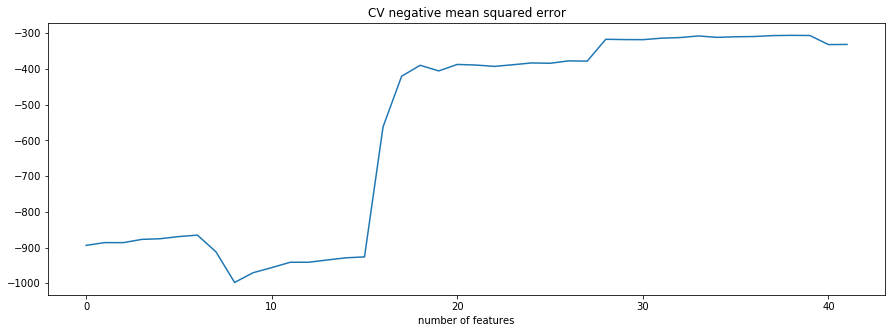

In [25]:
cv_results = pd.DataFrame.from_dict({'cv_score': regr_pipe.named_steps['rfecv'].grid_scores_})
cv_results['mean_squared_error'] = cv_results['cv_score']
plt.figure(figsize=(15, 5))
plt.plot(cv_results.index, cv_results['mean_squared_error'])
plt.xlabel('number of features')
plt.title('CV negative mean squared error')
plt.show()

La mayoria de las features son relevantes para el modelo.

In [26]:
# Número de features selecciondas:
regr_pipe.named_steps['rfecv'].n_features_

39

In [27]:
# Identificamos las features admitidas después del proceso de selección:
def get_onehot_cols(X):
    X_dummy_cols = list(pd.get_dummies(X.copy()[cat_cols], columns=cat_cols).columns)
    other_cols = list(X.columns.drop(cat_cols))
    return X_dummy_cols + other_cols

In [28]:
supported_features = pd.DataFrame.from_dict(
    {'feature':get_onehot_cols(X), 
     'supported':regr_pipe.named_steps['rfecv'].support_}
)

In [29]:
supported_features

,feature,supported
0,mes_0,True
1,mes_1,True
2,mes_2,True
3,mes_3,True
4,mes_4,True
5,mes_5,True
6,mes_6,True
7,mes_7,True
8,mes_8,True
9,mes_9,True
